In [13]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import function_library_assignment_2 as fnc

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
random.seed(2) #seed to ensure that we can get the same random values again
wind_scenarios = random.sample(range(100), 50) #How many scenarios? Sampling without replacement - taking 100 samples will just get a list from 0 to 99
wind_scenarios.sort()
#wind_scenarios

In [15]:
wind_hour = 31
n_bus = 24
gen_data = fnc.read_data('gen_data')
system_demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_data = fnc.read_data('gen_data')
gen_costs = fnc.read_data('gen_costs')[['C ($/MWh)', 'C+($/MWh)', 'C-($/MWh)']]
#line_data = fnc.read_data('line_data')
#branch_matrix = fnc.read_data('branch_matrix')
wind_data = fnc.read_data('wind_data', wind_hour=wind_hour, wind_scenarios=wind_scenarios) #The ED is only for a single hour - in this case, we choose hour 31

In [16]:
wind_data

,V4,V5,V8,V9,V11,V12,V21,V22,V23,V24,...,V87,V88,V91,V92,V94,V95,V96,V97,V99,Expected
Wind Farm,,,,,,,,,,,,,,,,,,,,,
1,57.283818,77.715628,54.768202,88.261022,61.526138,110.606595,71.048138,77.941511,115.265724,57.290970,...,69.476383,70.440895,69.200962,72.376635,49.645390,133.940655,145.616105,104.537623,67.364359,87.835313
2,54.448479,36.666436,82.923284,118.740668,74.314308,172.252597,46.524512,91.438267,95.294579,71.927771,...,23.531152,90.802922,172.267049,76.482999,54.133353,65.006056,119.320632,93.820298,76.892374,84.949445
3,82.765582,22.087288,159.624842,119.688707,131.081276,189.099842,74.890563,50.628220,71.082021,69.595260,...,90.579292,103.925204,83.008728,73.247895,152.920123,76.477575,109.009043,62.662894,159.706527,95.183126
4,36.095578,59.738306,104.588929,126.923187,93.205448,155.167339,90.246099,54.321054,60.760307,64.767642,...,115.046856,92.781188,93.586157,52.605840,119.336831,59.241252,180.076692,45.007126,105.682757,94.176785
5,30.088573,52.926868,40.394678,50.969494,60.829099,66.375056,71.842607,52.528677,37.534844,43.592536,...,76.268240,22.964236,115.224042,29.538075,20.283230,37.582726,36.294670,58.142245,20.197243,53.941011
6,3.270805,21.481439,34.243755,41.166235,23.600974,42.658839,65.357093,85.239538,83.086019,10.330277,...,1.332176,5.308145,17.469619,45.184566,61.698552,100.684235,26.365080,41.548993,57.981931,54.712901


In [17]:
wind_data.loc[wind_data.index == 1].index

Int64Index([1], dtype='int64', name='Wind Farm')

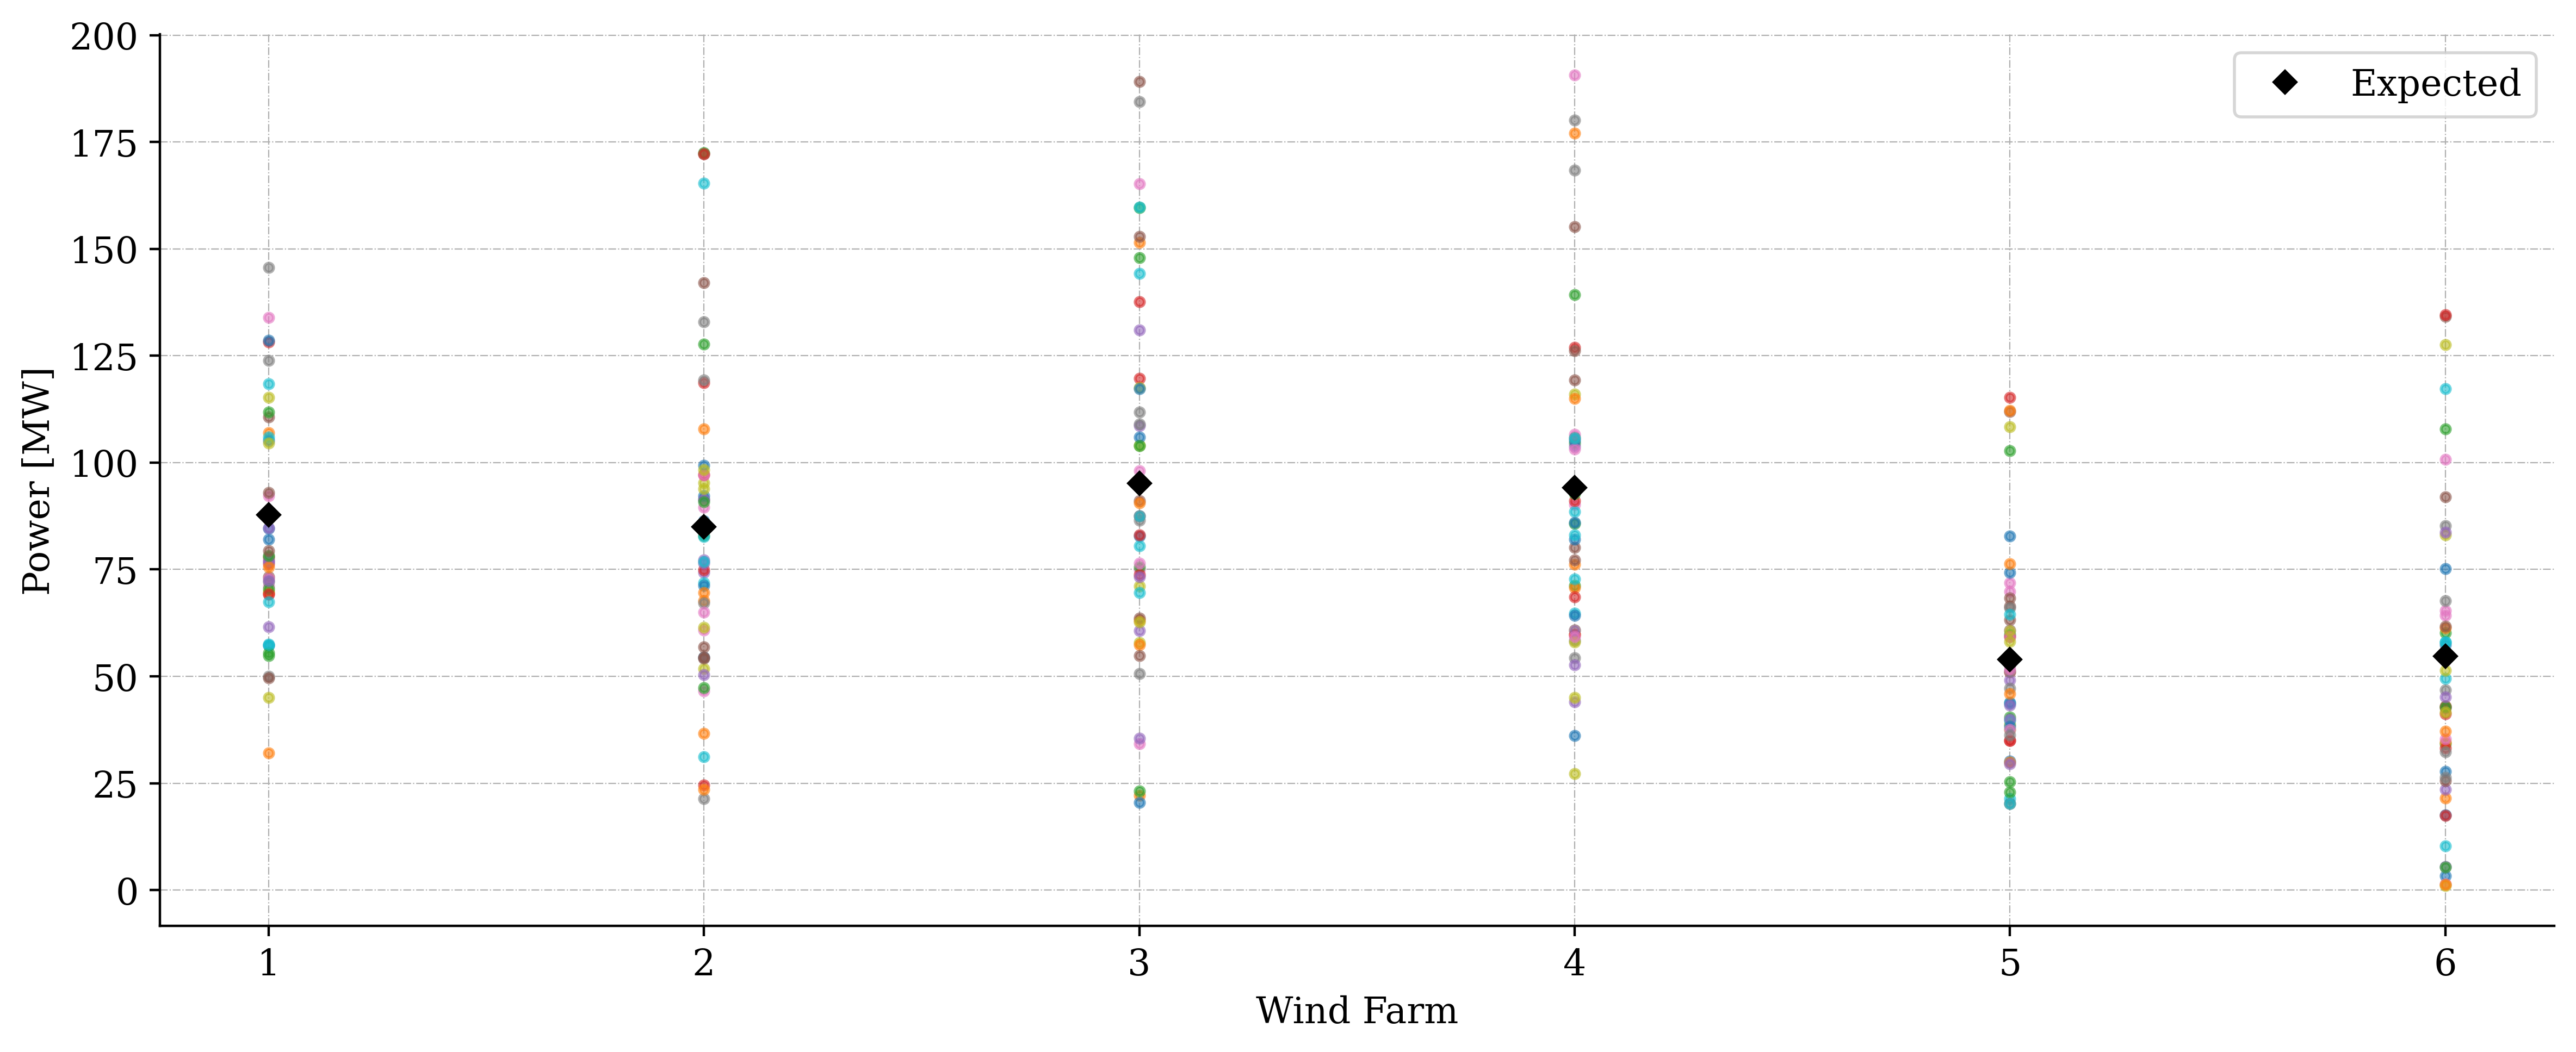

In [67]:
fig = plt.figure(figsize=( 12 , 5 ), dpi=400) # Create the figure
ax = fig.gca()
i = 1

for n in range(2):
    for k in range(3):
        ax.plot(wind_data.loc[wind_data.index == i][wind_data.columns[:-1].to_numpy()], alpha=0.6, linestyle='', marker='o', markersize=3)
        #ax.spines[['right', 'top']].set_visible(True)
        ax.plot(wind_data.loc[wind_data.index == i,'Expected'], color='black', linestyle='', marker='D', markersize=5)
        #ax.set_title('Wind Farm %d' % (i))

        i += 1
        ax.set_xlabel('Wind Farm')

    ax.set_ylabel('Power [MW]')

ax.plot(wind_data.loc[wind_data.index == i,'Expected'], color='black', linestyle='', marker='D', label = 'Expected', markersize=5)
plt.legend(loc = 'upper right')

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/wind_data_hour.png')
plt.show()

Assumption: Based on the exercises, we set the day-ahead cost of the wind farm to be 5% of the average cost of the gens and the regulation cost to be 10% of the average regulation cost of the gens

In [20]:
wf_costs = gen_costs.iloc[0:6].copy()
wf_costs['C ($/MWh)'] = 0.05 * gen_costs['C ($/MWh)'].mean()
wf_costs['C+($/MWh)'] = 0.1 * gen_costs['C+($/MWh)'].mean()
wf_costs['C-($/MWh)'] = 0.1 * gen_costs['C-($/MWh)'].mean()
wf_costs

,C ($/MWh),C+($/MWh),C-($/MWh)
0,0.618,1.408333,0.9
1,0.618,1.408333,0.9
2,0.618,1.408333,0.9
3,0.618,1.408333,0.9
4,0.618,1.408333,0.9
5,0.618,1.408333,0.9


"The commitment and ramping constraints and costs of all generators can be neglected."

In [21]:
gen_data = gen_data[['Unit #', 'Node', 'P max MW', 'R+ MW',	'R- MW']]
gen_data

,Unit #,Node,P max MW,R+ MW,R- MW
0,1,1,152,40,40
1,2,2,152,40,40
2,3,7,350,70,70
3,4,13,591,180,180
4,5,15,60,60,60
5,6,15,155,30,30
6,7,16,155,30,30
7,8,18,400,0,0
8,9,21,400,0,0
9,10,22,300,0,0


# Task 1b - Stochastic

### Setup model and solve

In [22]:
t = 0 #hour
demand = system_demand[t]

n_gen = len(gen_data.index)
n_wf = len(wind_data.index)
n_scenarios = len(wind_scenarios)
p_max_wf = 300

In [23]:
gen_data

,Unit #,Node,P max MW,R+ MW,R- MW
0,1,1,152,40,40
1,2,2,152,40,40
2,3,7,350,70,70
3,4,13,591,180,180
4,5,15,60,60,60
5,6,15,155,30,30
6,7,16,155,30,30
7,8,18,400,0,0
8,9,21,400,0,0
9,10,22,300,0,0


In [28]:
direction = gb.GRB.MINIMIZE #Min / Max

# Create a Gurobi model
m = gb.Model()
m.setParam("OutputFlag", 0)

# Add variables
p_G = m.addVars(n_gen, lb=0, ub=gb.GRB.INFINITY, name="P_G") #Note: This is in MW
p_W = m.addVars(n_wf, lb=0, ub=gb.GRB.INFINITY, name="P_W") #Note: Wind farms can be curtailed
p_G_UP = m.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_UP")
p_G_DOWN = m.addVars(n_gen, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_G_DOWN")
p_W_UP = m.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_UP")
p_W_DOWN = m.addVars(n_wf, n_scenarios, lb=0, ub=gb.GRB.INFINITY, name="p_W_DOWN")

# Set objective function
obj = gb.quicksum(gen_costs['C ($/MWh)'][g] * p_G[g] for g in range(n_gen)) + gb.quicksum(wf_costs['C ($/MWh)'][w] * p_W[w] for w in range(n_wf)) + 1 / n_scenarios * (
                      gb.quicksum((gen_costs['C+($/MWh)'][g] * p_G_UP[g,k] - gen_costs['C-($/MWh)'][g] * p_G_DOWN[g,k]) for g in range(n_gen) for k in range(n_scenarios))
                      + gb.quicksum((wf_costs['C+($/MWh)'][w] * p_W_UP[w,k] - wf_costs['C-($/MWh)'][w] * p_W_DOWN[w,k]) for w in range(n_wf) for k in range(n_scenarios))
                      )

m.setObjective(obj, gb.GRB.MINIMIZE) #Minimization / Maximization

#Day-ahead balance constraint
m.addConstr(gb.quicksum(p_G[g] for g in range(n_gen)) + gb.quicksum(p_W[w] for w in range(n_wf)) - demand == 0)

#Real-time balance constraint
m.addConstrs(gb.quicksum(p_G_UP[g,k] - p_G_DOWN[g,k] for g in range(n_gen)) + gb.quicksum(p_W_UP[w,k] - p_W_DOWN[w,k] for w in range(n_wf)) == 0 for k in range(n_scenarios))

#Output day-ahead limits
m.addConstrs(p_G[g] <= gen_data['P max MW'][g] for g in range(n_gen))

#Real-time limits
m.addConstrs(p_G[g] + p_G_UP[g,k] - p_G_DOWN[g,k] >= 0 for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_W[w] + p_W_UP[w,k] - p_W_DOWN[w,k] >= 0 for w in range(n_wf) for k in range(n_scenarios))

m.addConstrs(p_G[g] + p_G_UP[g,k] - p_G_DOWN[g,k] <= gen_data['P max MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_W[w] + p_W_UP[w,k] - p_W_DOWN[w,k] <= wind_data[wind_data.columns[k]][w + 1] for w in range(n_wf) for k in range(n_scenarios)) #accounting for wind scenario

#Real-time regulating power bounds
m.addConstrs(p_G_UP[g,k] <= gen_data['R+ MW'][g] for g in range(n_gen) for k in range(n_scenarios))
m.addConstrs(p_G_DOWN[g,k] <= gen_data['R- MW'][g] for g in range(n_gen) for k in range(n_scenarios))

m.addConstrs(p_W_UP[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))
m.addConstrs(p_W_DOWN[w,k] <= p_max_wf for w in range(n_wf) for k in range(n_scenarios))

m.update()
#m.display()

m.optimize()

### Analyze results

In [40]:
#Print solutions
if m.status == gb.GRB.OPTIMAL:
    results = {} #to be included: branch flows, theta, generator outputs
    generator_outputs = pd.DataFrame(data=np.zeros(n_gen), columns=['p_G'])
    generator_outputs['Node'] = gen_data['Node'].values
    generator_outputs['Loading Percentage'] = 0

    wf_outputs = pd.DataFrame(data=np.zeros(n_wf), columns=['p_W'])
    wf_outputs['Node'] = wf_costs.index + 1
    wf_outputs['Loading Percentage'] = 0
    wf_outputs['Expected Production'] = wind_data['Expected'].values

    constraints = m.getConstrs()
    # The constraint dual value / sensitivity in the current solution (also known as the shadow price)... https://www.gurobi.com/documentation/9.5/refman/pi.html
    dual_values = [constraints[k].Pi for k in range(len(constraints))] 
    print('-----------------------------------------------')
    print("Optimal objective value: %.2f $" % m.objVal)

    for i in range(n_gen):
        print(p_G[i].VarName + ": %.2f MW" % p_G[i].x)
        generator_outputs.loc[generator_outputs.index == i, 'p_G'] = p_G[i].x
        gen_limit = gen_data.loc[gen_data.index == i, 'P max MW']
        generator_outputs.loc[generator_outputs.index == i, 'Loading Percentage'] = (p_G[i].x / gen_limit) * 100

    for i in range(n_wf):
        print(p_W[i].VarName + ": %.2f MW" % p_W[i].x)
        wf_outputs.loc[wf_outputs.index == i, 'p_W'] = p_W[i].x
        wf_outputs.loc[wf_outputs.index == i, 'Loading Percentage'] = (p_W[i].x / p_max_wf) * 100

    for k in range(0, (1 + n_scenarios + n_gen)): #printing the dual values for the balance constraints and the generator limit constraints
        print('Dual value {0}: '.format(k+1), dual_values[k])

    sum_wind = sum(p_W[n].x for n in range(n_wf))
    sum_gen = sum(p_G[n].x for n in range(n_gen))
    sum_production = sum_wind + sum_gen
    print("\nTotal load: %.1f MWh" % demand)
    print("Total generation: %.1f MWh" % sum_production)

    results['gen'] = generator_outputs.copy(deep=True)
    results['wind'] = wf_outputs.copy(deep=True)

else:
    print("Optimization was not successful.")     


-----------------------------------------------
Optimal objective value: 7567.75 $
P_G[0]: 0.00 MW
P_G[1]: 0.00 MW
P_G[2]: 0.00 MW
P_G[3]: 0.00 MW
P_G[4]: 0.00 MW
P_G[5]: 30.00 MW
P_G[6]: 30.00 MW
P_G[7]: 400.00 MW
P_G[8]: 400.00 MW
P_G[9]: 300.00 MW
P_G[10]: 119.15 MW
P_G[11]: 40.00 MW
P_W[0]: 79.41 MW
P_W[1]: 86.37 MW
P_W[2]: 95.56 MW
P_W[3]: 91.03 MW
P_W[4]: 52.93 MW
P_W[5]: 51.39 MW
Dual value 1:  10.52
Dual value 2:  0.32
Dual value 3:  0.32
Dual value 4:  0.16
Dual value 5:  0.16
Dual value 6:  0.28
Dual value 7:  0.02816666666666667
Dual value 8:  0.28
Dual value 9:  0.28
Dual value 10:  0.16
Dual value 11:  0.3
Dual value 12:  0.3
Dual value 13:  0.14
Dual value 14:  0.16
Dual value 15:  0.32
Dual value 16:  0.16
Dual value 17:  0.02816666666666667
Dual value 18:  0.14
Dual value 19:  0.32
Dual value 20:  0.3
Dual value 21:  0.14
Dual value 22:  0.16
Dual value 23:  0.3
Dual value 24:  0.3
Dual value 25:  0.28
Dual value 26:  0.3
Dual value 27:  0.3
Dual value 28:  0.3
Dual val

3 x 6 with loading plots at the bottom and wind included next to generators


In [42]:
results.get('gen')

,p_G,Node,Loading Percentage
0,0.000000,1,0.000000
1,0.000000,2,0.000000
2,0.000000,7,0.000000
3,0.000000,13,0.000000
4,0.000000,15,0.000000
5,30.000000,15,19.354839
6,30.000000,16,19.354839
7,400.000000,18,100.000000
8,400.000000,21,100.000000
9,300.000000,22,100.000000


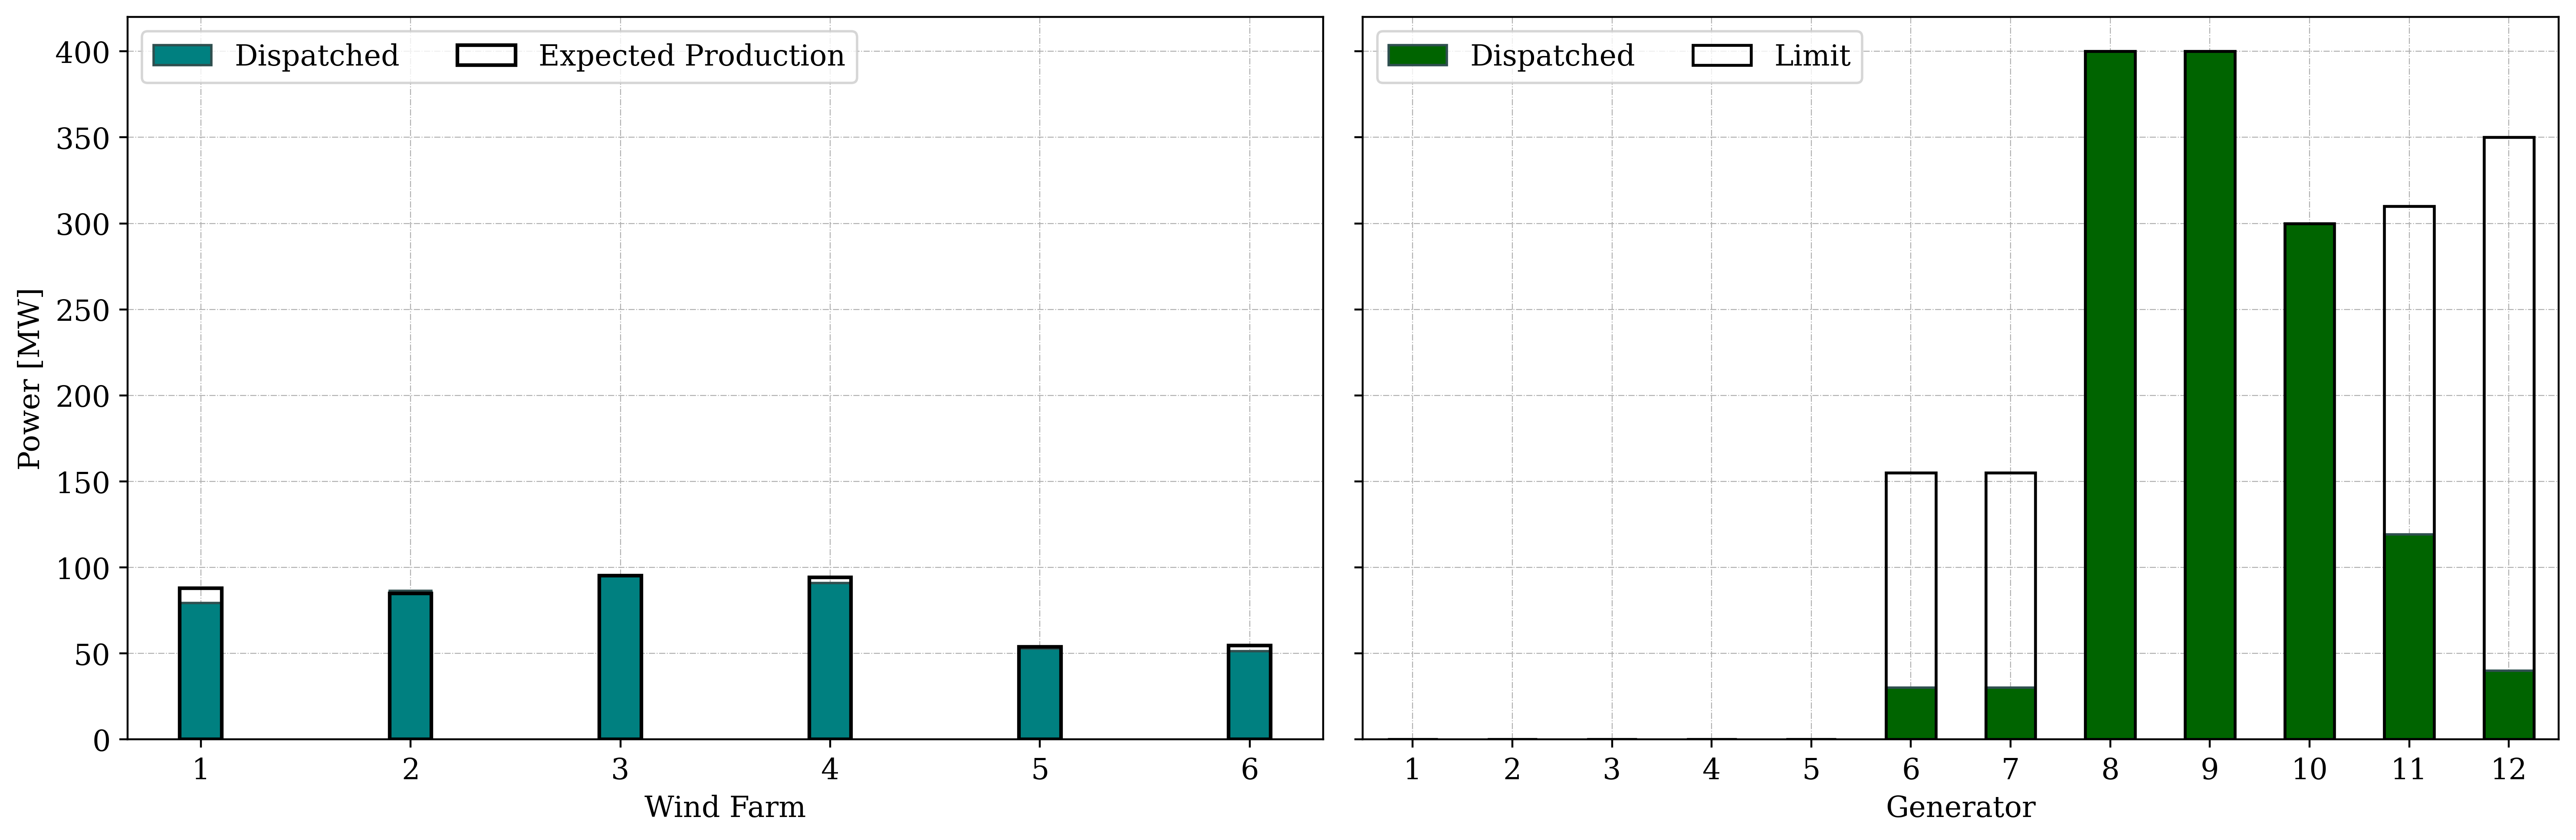

In [61]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=( 15 , 5 ), dpi=400) # Create the figure

(results.get('wind')['p_W']).plot(kind='bar', ax=ax[0], color='teal', width=0.2, label='Dispatched', edgecolor='darkslategrey')
(results.get('wind')['Expected Production']).plot(kind='bar', ax=ax[0], width=0.2, edgecolor='black', linestyle='-', fill=False, linewidth=1.5, label='Expected Production')
ax[0].set_ylabel('Power [MW]')
ax[0].set_xlabel('Wind Farm')
ax[0].set_xticks(ticks = np.arange(0, n_wf), labels = np.arange(1, n_wf + 1), fontsize=12, rotation = 0)
ax[0].legend(loc='upper left', ncol=2, fontsize=12)

(results.get('gen')['p_G']).plot(kind='bar', ax=ax[1], color='darkgreen', label='Dispatched', edgecolor='darkslategrey')
((results.get('gen')['p_G']) / ((results.get('gen')['Loading Percentage']) / 100)).plot(kind='bar', ax=ax[1], edgecolor='black', linestyle='-', fill=False, linewidth=1.2, label='Limit')
#ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Generator')
ax[1].set_xticks(ticks = np.arange(0, n_gen), labels = np.arange(1, n_gen + 1), fontsize=12, rotation = 0)
ax[1].legend(loc='upper left', ncol=2, fontsize=12)

for k in range(2):
    ax[k].spines[['right', 'top']].set_visible(True)
    ax[k].set_axisbelow(True)

fig.tight_layout() # reduces white space around figures
plt.savefig('Figures/task_1_results_gen_dispatch.png',bbox_inches='tight')
plt.show()

# Task 1c - Deterministic

# Task 1d - Real-time Adjustments